In [1]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal, multivariate_t, norm
import networkx as nx
import yfinance as yf
import sys
sys.path.insert(0, 'C:/Users/User/Code/DyGraph/src')
sys.path.insert(0, 'C:/Users/User/Code/DyGraph')

import DyGraph as dg
import port_measures as pm
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import scipy
from scipy.optimize import minimize

import pickle

# R stuff
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
HDtest = importr('HDtest')



In [4]:
def gen_all_all_zero(d,s, v1 = 1.1, v2 = 1.1):

    while True:
        # G =nx.erdos_renyi_graph(d, s, seed=42)


        # A = np.array(nx.adjacency_matrix(G).todense())
        # A[np.tril_indices(d)] = 0
        # U = np.random.binomial(1,0.5,  size = (d,d))
        # A = np.multiply(A, U*np.random.uniform(-0.6,-0.2, size = (d,d)) + (1-U)*np.random.uniform(0.2,0.6, size = (d,d)))
        # A = A+A.T
        # np.fill_diagonal(A, np.sum(np.abs(A),axis=1))


        k = d
        sparsity = s
        # generate the symmetric sparsity mask
        mask = np.random.uniform(size=(k,k))
        mask = mask * (mask < sparsity)
        mask[np.tril_indices(k,0)] = 0
        mask = mask + mask.T + np.identity(k)
        mask[mask > 0] = 1

        # generate the symmetric precision matrix
        A = np.random.uniform( size = (k,k))
        A[np.tril_indices(k,0)] = 0
        A = A + A.T + np.identity(k)

        # apply the reqired sparsity
        A = A * mask

        # force it to be positive definite
        l,u = np.linalg.eigh(A)
        A = A - (np.min(l)-.1) * np.identity(k)

        A2 = A.copy()
        A2_SIGNS = np.sign(A2)
        A2 = np.power(np.abs(A2), v1)
        A2 = A2*A2_SIGNS
        np.fill_diagonal(A2,np.diag(A))

        A3 = A2.copy()
        A3_SIGNS = np.sign(A3)
        A3 = np.power(np.abs(A3), v2)
        A3 = A3*A3_SIGNS
        np.fill_diagonal(A3,np.diag(A))


        try:
            np.linalg.inv(A)
            np.linalg.inv(A2)
            np.linalg.inv(A3)
        except:
            continue


        break

    return np.array([A, A2, A3])


def my_hdtest(Z, cov_Z, Y, cov_Y):

    d = Z.shape[1]
    n1 = Z.shape[0]
    n2 = Y.shape[0]



    za = (Z - np.mean(Z,0))
    vz = np.dot((za**2).T, za**2)/n1 - (2/n1 )*np.dot(za.T, za)*cov_Z + cov_Z**2


    ya = (Y - np.mean(Y,0))
    vy = np.dot((ya**2).T, ya**2)/n2 - (2/n2 )*np.dot(ya.T, ya)*cov_Y + cov_Y**2


    CLX = np.max((cov_Z-cov_Y)**2/(vz/n1+vy/n2))


    CLX_test = CLX-(4*np.log(d)-np.log(np.log(d)))
    p_val = 1 - np.exp(-np.exp(-CLX_test/2)/(np.sqrt(8*np.pi)))
    return p_val, CLX_test


def hdtest_boot(Z, cov_Z, Y, cov_Y, B):

    test_stat = np.zeros(B)

    X = np.vstack((Z,Y))

    _,t_stat_sample= my_hdtest(Z, cov_Z, Y, cov_Y)
    
    for i in range(B):
        
        #from sklearn.model_selection import train_test_split
        #X1_tmp, X2_tmp = train_test_split(X, test_size=0.5)

        X1_tmp = X[np.random.choice(X.shape[0], X.shape[0])]
        X2_tmp = X[np.random.choice(X.shape[0], X.shape[0])]
        p,test_stat[i] = my_hdtest(X1_tmp, cov_Z, X2_tmp, cov_Y) # out['statistics'][0] #
    
    return np.sum(test_stat >t_stat_sample)/len(test_stat),t_stat_sample,test_stat



def gen_local_change(d, s):

    k = d
    sparsity = s
    rnd = np.random.RandomState(42)
    while True:

        # generate the symmetric sparsity mask
        mask = rnd.uniform(size=(k,k))
        mask = mask * (mask < sparsity)
        mask[np.tril_indices(k,0)] = 0
        mask = mask + mask.T + np.identity(k)
        mask[mask > 0] = 1

        # generate the symmetric precision matrix
        A = rnd.uniform( size = (k,k))
        A[np.tril_indices(k,0)] = 0
        A = A + A.T + np.identity(k)

        # apply the reqired sparsity
        A = A * mask

        # force it to be positive definite
        l,u = np.linalg.eigh(A)
        A = A - (np.min(l)-.5) * np.identity(k)

        A2 = A.copy()
        shut_index = rnd.uniform(low =0, high = 0.5, size = A.shape)
        shut_index = shut_index +shut_index.T
        np.fill_diagonal(shut_index,1)
        shut_index = shut_index <0.3
        A2[shut_index] = 0


        for i in range(k):
            for j in range(i+1, k):
                if rnd.uniform()<0.3:
                    A2[i,j] = rnd.uniform(low = -1, high = 1)
                    A2[j,i] = A2[i,j]


        A3 = A2.copy()
        shut_index = rnd.uniform(low =0, high = 0.5, size = A.shape)
        shut_index = shut_index +shut_index.T
        np.fill_diagonal(shut_index,1)
        shut_index = shut_index <0.3
        A3[shut_index] = 0

        for i in range(k):
            for j in range(i+1, k):
                if rnd.uniform()<0.3:
                    A3[i,j] = rnd.uniform(low = -1, high = 1)
                    A3[j,i] = A3[i,j]



        try:
            u = np.linalg.eigvals(A)
            assert np.all(u>=0)
            u = np.linalg.eigvals(A2)
            assert np.all(u>=0)
            u = np.linalg.eigvals(A3)
            assert np.all(u>=0)
        except: 
            continue

        break




    return np.array([A, A2, A3])

In [5]:
def log_lik(mean,cov, X, liktype, nu = None, prec = None, gamma = None, n = 10):

    if liktype == "gaussian":
        lik = np.sum(multivariate_normal.logpdf(X, mean=mean, cov=cov, allow_singular=True))
    elif liktype == "t":
        lik = np.sum(multivariate_t.logpdf(X,loc = mean, shape=cov, df = nu))
    elif np.isin(liktype, ("skew-group-t", "group-t")):
        lik  = 0.0
        #print(X)
        for i in range(X.shape[0]):
            lik += np.log(dg.generalized_skew_t( X[i], prec, nu = nu, gamma = gamma, n = n))
    else:
        assert False, "likelihood not correct"

    return lik

def log_lik_all(w, thetas, X, lik_type, nus = None, gammas = None):

    if gammas is None:
        gammas = [None] * len(thetas)
    
    if nus is None:
        nus = [None] * len(thetas)

    lik_tmp = []
    for j in range(len(thetas)):
        lik_tmp.append(log_lik(np.zeros(thetas[j].shape[1]) ,np.linalg.inv(thetas[j]), X[j*w:(j+1)*w], liktype = lik_type, prec =thetas[j],  nu = nus[j], gamma = gammas[j]))

    return np.array(lik_tmp)
            
def find_nr_params(thetas, lik_type):
    
    nr_params_tmp = []
    for iii in range(len(thetas)):
        theta_t = thetas[iii].copy()
        theta_t[np.abs(theta_t)<1e-4] = 0
        if lik_type == 't':
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0) + 1.0)
        elif lik_type == 'group-t':
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0) + float(theta_t.shape[0]))
        elif lik_type == 'skew-group-t':
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0) + float(theta_t.shape[0]) + float(theta_t.shape[0]))
        else:
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0))

    return np.array(nr_params_tmp)




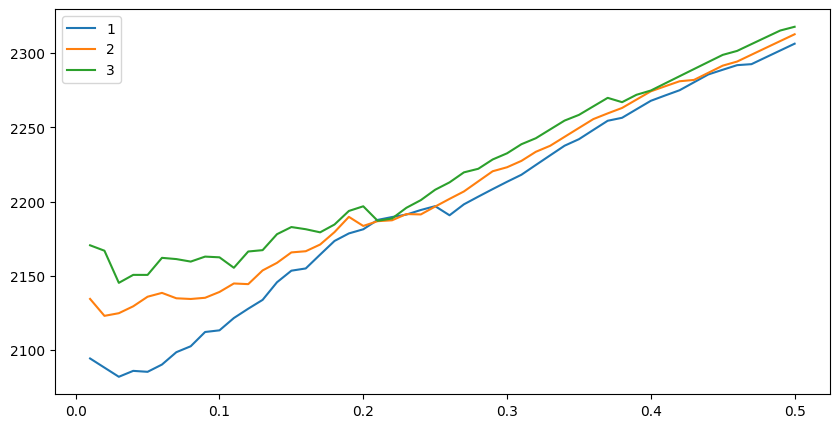

In [4]:
d = 10
As = gen_local_change(10,0.3)


rnd = np.random.RandomState(10)

X1 = rnd.multivariate_normal(mean = np.zeros(d),  cov = np.linalg.inv(As[0]), size = 50)
X2 = rnd.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(As[1]), size = 30)
X3 = rnd.multivariate_normal(mean = np.zeros(d),  cov =  np.linalg.inv(As[2]), size = 10)

X = np.vstack([X1,X2,X3])

alphas = np.linspace(0.01,0.5, 50)
kappas = [0.01, 0.05, 0.1]
AICs = np.empty((len(kappas), len(alphas)))

for k_cnt, kappa in enumerate(kappas):
    for a_cnt, alpha in enumerate(alphas):
        dg_opt1 = dg.dygl_inner_em(X, obs_per_graph = 30, max_iter = 10000, lamda = alpha, kappa = kappa, tol = 1e-6)
        dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)

        thetas = dg_opt1.theta
        liks = log_lik_all(30, thetas, X, 'gaussian')
        nr_params_val = find_nr_params(thetas, 'gaussian')
        AICs[k_cnt, a_cnt] = 2*(np.sum(nr_params_val) - np.sum(liks))


fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(alphas, AICs[0], label = 1)
ax.plot(alphas, AICs[1], label = 2)
ax.plot(alphas, AICs[2], label = 3)
ax.legend()

In [5]:


B = scipy.stats.bernoulli.rvs(p = 0.5, size = (45))   

reg_matrix = np.zeros((3,d,d))
for h in range(1):
    np.fill_diagonal(reg_matrix[h],0)
    reg_matrix[h][np.triu_indices(d,1)] = B*999999
    reg_matrix[h] = reg_matrix[h] + reg_matrix[h].T


dg_opt1 = dg.dygl_inner_em(X, obs_per_graph = 30, max_iter = 10000, lamda = reg_matrix, kappa = kappa, tol = 1e-6)
dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)




In [36]:
with open(f'../data/GraphHypTest/known_cp_50_zero-one_xs_xs_False.pkl', 'rb') as handle:
    graph_sampling_testing = pickle.load(handle)

graph_sampling_testing.keys()

dict_keys(['alphas', 'kappas', 'p_distribution', 'thetas', 'thetas_sim', 'X', 'As', 'N', 'nr_ce_it', 'ratio_nr_zeros', 'obs_per_graph', 'alpha_in_CE', 'model', 'sigmas', 'used'])

In [167]:
graph_sampling_testing['thetas'].shape

(2, 9, 3, 10, 10)

In [7]:
kappas

[0.01, 0.05, 0.1]

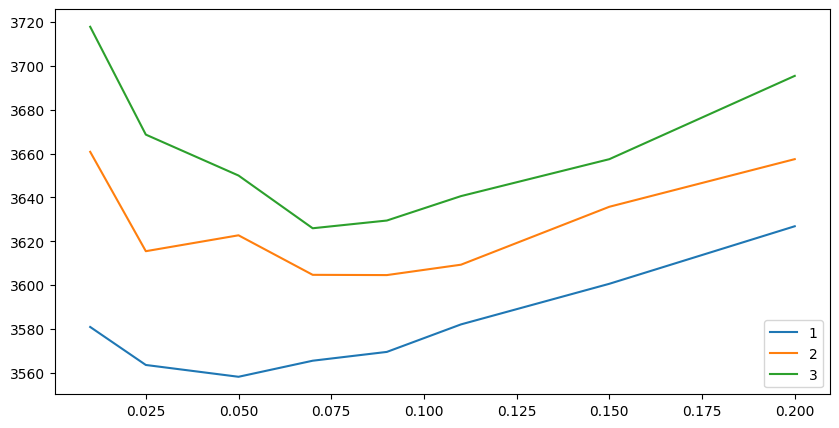

In [29]:

X = graph_sampling_testing['X'] #np.vstack([X1,X2,X3])

alphas = graph_sampling_testing['alphas']# np.linspace(0.01,0.5, 50)
kappas = graph_sampling_testing['kappas'] #[0.01, 0.05, 0.1]
AICs = np.empty((len(kappas), len(alphas)))

for k_cnt, kappa in enumerate(kappas):
    for a_cnt, alpha in enumerate(alphas):
        dg_opt1 = dg.dygl_inner_em(graph_sampling_testing['X'], obs_per_graph = 30, max_iter = 10000, lamda = alpha, kappa = kappa, tol = 1e-6)
        dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)

        thetas = dg_opt1.theta
        liks = log_lik_all(30, thetas, X, 'gaussian')
        nr_params_val = find_nr_params(thetas, 'gaussian')
        AICs[k_cnt, a_cnt] = 2*(np.sum(nr_params_val) - np.sum(liks))


fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(alphas, AICs[0], label = 1)
ax.plot(alphas, AICs[1], label = 2)
ax.plot(alphas, AICs[2], label = 3)
ax.legend()

In [9]:
dg_opt1 = dg.sgl_inner_em(graph_sampling_testing['X'][:30], max_iter = 10000, lamda = 0.09, tol = 1e-6)
dg_opt1.fit(nr_workers=1, lik_type="gaussian",verbose=False)
thetas = dg_opt1.theta

print(np.round(thetas[0],2))

[[ 1.66  0.    0.06 -0.48  0.    0.   -0.    0.   -0.    0.12]
 [ 0.    1.9  -0.13  0.61 -0.   -0.19  0.    0.7  -0.    0.  ]
 [ 0.06 -0.13  1.74  0.   -0.   -0.12  0.42  0.   -0.   -0.  ]
 [-0.48  0.61  0.    1.85  0.    0.   -0.   -0.61  0.06  0.19]
 [ 0.   -0.   -0.    0.    2.11 -0.    0.26  0.   -0.   -0.  ]
 [ 0.   -0.19 -0.12  0.   -0.    1.97  0.    0.   -0.   -0.  ]
 [-0.    0.    0.42 -0.    0.26  0.    1.94 -0.    0.    0.  ]
 [ 0.    0.7   0.   -0.61  0.    0.   -0.    2.09 -0.   -0.  ]
 [-0.   -0.   -0.    0.06 -0.   -0.    0.   -0.    2.01  0.  ]
 [ 0.12  0.   -0.    0.19 -0.   -0.    0.   -0.    0.    2.04]]


In [10]:
dg_opt1 = dg.dygl_inner_em(graph_sampling_testing['X'], obs_per_graph = 30, max_iter = 10000, lamda = 0.09, kappa = 0.01, tol = 1e-6)
dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)

thetas = dg_opt1.theta

print(np.round(thetas[0],2))
print(np.round(thetas[1],2))


[[ 1.86 -0.    0.21 -0.62  0.    0.   -0.    0.   -0.    0.29]
 [-0.    2.31 -0.2   0.75  0.   -0.33 -0.    0.94 -0.12 -0.  ]
 [ 0.21 -0.2   2.06 -0.   -0.   -0.34  0.71  0.01  0.    0.  ]
 [-0.62  0.75 -0.    2.27 -0.   -0.   -0.04 -0.8   0.14  0.31]
 [ 0.    0.   -0.   -0.    2.2  -0.    0.58  0.01  0.    0.  ]
 [ 0.   -0.33 -0.34 -0.   -0.    2.18  0.02 -0.   -0.21  0.  ]
 [-0.   -0.    0.71 -0.04  0.58  0.02  2.22 -0.    0.15 -0.  ]
 [ 0.    0.94  0.01 -0.8   0.01 -0.   -0.    2.49 -0.   -0.  ]
 [-0.   -0.12  0.    0.14  0.   -0.21  0.15 -0.    2.09  0.  ]
 [ 0.29 -0.    0.    0.31  0.    0.   -0.   -0.    0.    2.13]]
[[ 1.86  0.91  0.09  0.    0.    0.   -0.    0.14  0.19  0.23]
 [ 0.91  1.63  0.    0.15  0.38 -0.05 -0.24  0.72 -0.12 -0.  ]
 [ 0.09  0.    2.47 -0.   -0.   -0.    0.19  0.   -0.    0.  ]
 [ 0.    0.15 -0.    1.58 -0.   -0.28  0.    0.    0.04  0.18]
 [ 0.    0.38 -0.   -0.    1.96  0.25 -0.    0.    0.25 -0.37]
 [ 0.   -0.05 -0.   -0.28  0.25  2.18  0.    0.   -0. 

In [171]:
print(np.round(graph_sampling_testing['As'][0],2))
print(np.round(graph_sampling_testing['As'][1],2))

[[2.02 0.94 0.   0.   0.   0.   0.   0.52 0.   0.5 ]
 [0.94 2.02 0.   0.93 0.   0.   0.   0.88 0.   0.  ]
 [0.   0.   2.02 0.   0.   0.   0.35 0.   0.   0.  ]
 [0.   0.93 0.   2.02 0.   0.   0.   0.   0.4  0.15]
 [0.   0.   0.   0.   2.02 0.   0.97 0.   0.31 0.  ]
 [0.   0.   0.   0.   0.   2.02 0.   0.   0.   0.  ]
 [0.   0.   0.35 0.   0.97 0.   2.02 0.12 0.   0.  ]
 [0.52 0.88 0.   0.   0.   0.   0.12 2.02 0.   0.  ]
 [0.   0.   0.   0.4  0.31 0.   0.   0.   2.02 0.  ]
 [0.5  0.   0.   0.15 0.   0.   0.   0.   0.   2.02]]
[[ 2.02  0.94  0.51  0.    0.    0.    0.    0.52  0.09  0.5 ]
 [ 0.94  2.02  0.   -0.67  0.45  0.    0.01  0.88  0.    0.  ]
 [ 0.51  0.    2.02  0.    0.    0.13  0.    0.    0.    0.  ]
 [ 0.   -0.67  0.    2.02 -0.08 -0.51  0.    0.   -0.2   0.15]
 [ 0.    0.45  0.   -0.08  2.02  0.11  0.97  0.   -0.29  0.  ]
 [ 0.    0.    0.13 -0.51  0.11  2.02  0.    0.52  0.49  0.92]
 [ 0.    0.01  0.    0.    0.97  0.    2.02  0.12  0.   -0.39]
 [ 0.52  0.88  0.    0.    0

100%|██████████| 24/24 [00:00<00:00, 774.04it/s]


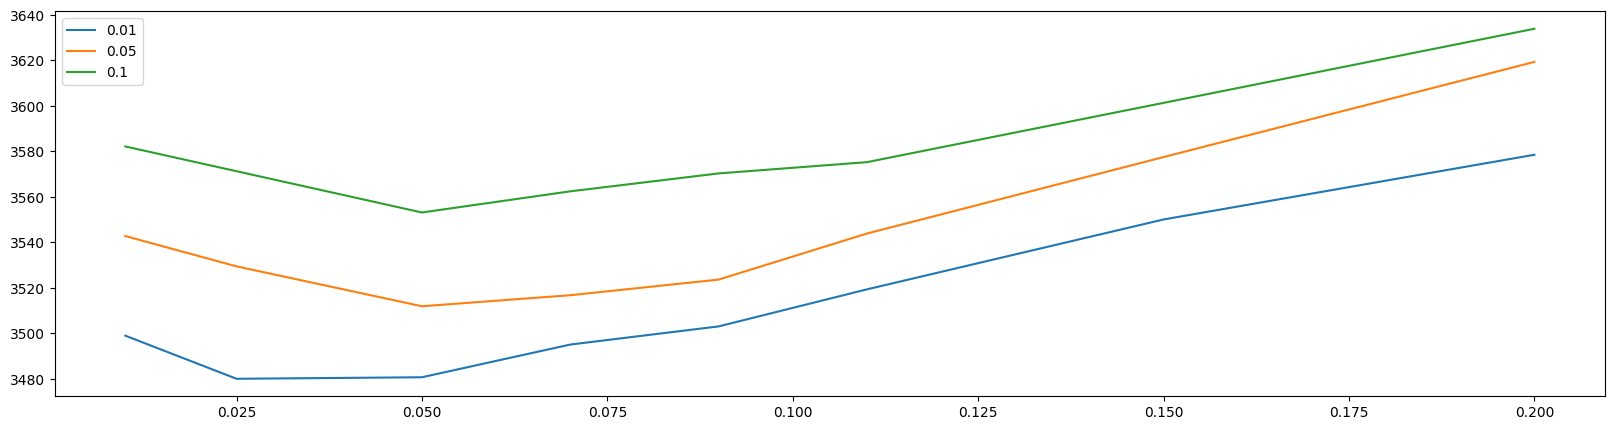

In [30]:
AICs = np.empty((len(graph_sampling_testing['kappas']), len(graph_sampling_testing['alphas'])))

pbar = tqdm.tqdm(total = np.prod(AICs.shape))

for k_cnt, kappa in enumerate(graph_sampling_testing['kappas']):
    for a_cnt, kappa in enumerate(graph_sampling_testing['alphas']):
        try:
            thetas = graph_sampling_testing['thetas'][k_cnt][a_cnt]
            liks = log_lik_all(50, thetas, graph_sampling_testing['X'], 'gaussian')
            nr_params_val = find_nr_params(thetas, 'gaussian')
            AICs[k_cnt, a_cnt] = 2*(np.sum(nr_params_val) - np.sum(liks))
        except:
            continue

        pbar.update()
pbar.close()

fig, ax = plt.subplots(1,1, figsize = (20,5))
for i in range(3):
    ax.plot(graph_sampling_testing['alphas'], AICs[i], label = np.round(graph_sampling_testing['kappas'][i],2))
ax.legend()
#ax.ylim(())
    
      

probability with iteration

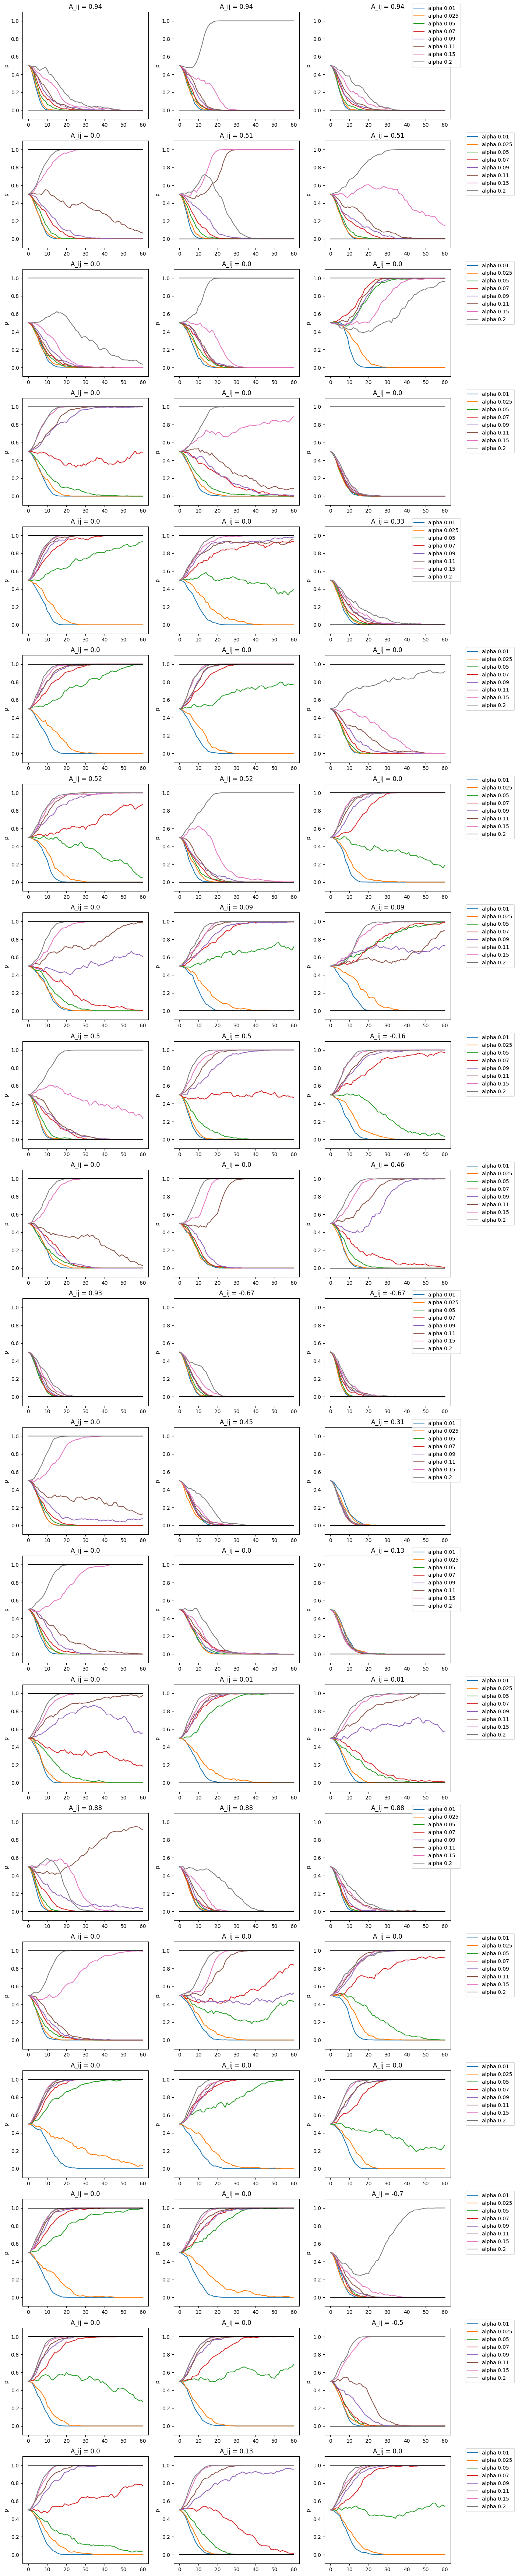

In [37]:
nr_ce_it = graph_sampling_testing['p_distribution'].shape[3]
# For binomial
fig, ax = plt.subplots(20,3, figsize = (15,90))
for i in range(20):
    for h in range(3):
        for k in [0]:
            for a in range(len(graph_sampling_testing['alphas'])):
                ax[i,h].plot(range(graph_sampling_testing['p_distribution'].shape[3]), graph_sampling_testing['p_distribution'][k,a,h,:,i], label = f'alpha {graph_sampling_testing["alphas"][a]}')
                #A_est = graph_sampling_testing['thetas'][h,j,k][np.triu_indices(20,1)]
                #A_est[np.abs(A_est)<1e-3] = 0
                #ax[i,h].plot(range(graph_sampling_testing['p_distribution'].shape[3]),[1-np.abs(np.sign(A_est[i]))]*61, color = 'orange')
        A_true = graph_sampling_testing['As'][h][np.triu_indices(10,1)]
        ax[i,h].plot(range(graph_sampling_testing['p_distribution'].shape[3]),[1-np.abs(np.sign(A_true[i]))]*nr_ce_it, color = 'black')
        #ax[i,h].set_xlabel('Iteration')
        ax[i,h].set_ylabel('p')
        ax[i,h].set_ylim((-0.1,1.1))
        ax[i,h].set_title(f"A_ij = {np.round(graph_sampling_testing['As'][h][np.triu_indices(10,1)][i],2)}")
    ax[i,2].legend(bbox_to_anchor = (1.1,1.1))


P to matrix

In [38]:
P = np.zeros((len(graph_sampling_testing['kappas']),len(graph_sampling_testing['alphas']),3,10,10))
for i in range(len(graph_sampling_testing['kappas'])):
    for j in range(len(graph_sampling_testing['alphas'])):
        for h in range(3):
            P[i,j,h][ np.triu_indices(10,1)] = graph_sampling_testing['p_distribution'][i,j,h,-1]
            P[i,j,h] =  P[i,j,h] +  P[i,j,h].T
            np.fill_diagonal(P[i,j,h],0)

histogram p

In [ ]:
sns.kdeplot(graph_sampling_testing['p_distribution'][0,0,h,-1])

AUC

In [39]:
from sklearn import metrics
fig, ax = plt.subplots(1,1, figsize = (10,10))
i = 0

for j in range(len(graph_sampling_testing['alphas'])):
    y = np.concatenate((np.sign(np.abs(graph_sampling_testing['As'][0][np.triu_indices(10,1)])), np.sign(np.abs(graph_sampling_testing['As'][1][np.triu_indices(10,1)])), np.sign(np.abs(graph_sampling_testing['As'][2][np.triu_indices(10,1)]))))
    pred = np.concatenate(( graph_sampling_testing['p_distribution'][i,j,0,-1],  graph_sampling_testing['p_distribution'][i,j,1,-1],  graph_sampling_testing['p_distribution'][i,j,2,-1]))

    fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=0)
    auc = metrics.roc_auc_score(1-y, pred)

    ax.plot(fpr, tpr,label="alpha = " + str(np.round(graph_sampling_testing['alphas'][j],2)) + ", auc="+str(np.round(auc,2)))
    ax.legend()

ax.plot([0,1], [0,1],color = 'black')



In [120]:
from sklearn import metrics
fig, ax = plt.subplots(1,1, figsize = (10,10))
i = 0

for j in [4]:#range(len(graph_sampling_testing['alphas'])):
    y = np.concatenate((np.sign(np.abs(graph_sampling_testing['As'][0][np.triu_indices(10,1)])), np.sign(np.abs(graph_sampling_testing['As'][1][np.triu_indices(10,1)])), np.sign(np.abs(graph_sampling_testing['As'][2][np.triu_indices(10,1)]))))
    pred = np.concatenate(( graph_sampling_testing['p_distribution'][i,j,0,-1],  graph_sampling_testing['p_distribution'][i,j,1,-1],  graph_sampling_testing['p_distribution'][i,j,2,-1]))
    fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=0)
    auc = metrics.roc_auc_score(1-y, pred)
    ax.plot(fpr, tpr,label="CE: alpha = " + str(np.round(graph_sampling_testing['alphas'][j],2)) + ", auc="+str(np.round(auc,2)))
    ax.legend()


    thetas = graph_sampling_testing['thetas']
    thetas[np.abs(thetas)<1e-10] = 0

    pred = np.concatenate((np.sign(np.abs(thetas[i,j,0][np.triu_indices(10,1)])),  
                           np.sign(np.abs(thetas[i,j,1][np.triu_indices(10,1)])),
                           np.sign(np.abs(thetas[i,j,2][np.triu_indices(10,1)]))))
    fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=0)
    auc = metrics.roc_auc_score(1-y, pred)
    ax.plot(fpr, tpr,label="Normal: alpha = " + str(np.round(graph_sampling_testing['alphas'][j],2)) + ", auc="+str(np.round(auc,2)))
    ax.legend()

ax.plot([0,1], [0,1],color = 'black')


In [86]:
j = 5
i = 0
print(np.sum((np.sign(np.abs(thetas[i,j,0][np.triu_indices(10,1)])) == 0 ) &  (np.sign(np.abs(graph_sampling_testing['As'][0][np.triu_indices(10,1)])) == 0)))
print(np.sum((graph_sampling_testing['p_distribution'][i,j,0,-1] >0.5) &  (np.sign(np.abs(graph_sampling_testing['As'][0][np.triu_indices(10,1)])) == 0)))


27
28


In [85]:
print(np.sum((np.sign(np.abs(thetas[i,j,0][np.triu_indices(10,1)])) != 0 ) &  (np.sign(np.abs(graph_sampling_testing['As'][0][np.triu_indices(10,1)])) != 0)))
print(np.sum((graph_sampling_testing['p_distribution'][i,j,0,-1] <0.3 ) &  (np.sign(np.abs(graph_sampling_testing['As'][0][np.triu_indices(10,1)])) != 0)))

8
8


In [84]:
print(np.sum((np.sign(np.abs(thetas[i,j,0][np.triu_indices(10,1)])) == 0 ) &  (np.sign(np.abs(graph_sampling_testing['As'][0][np.triu_indices(10,1)])) != 0)))
print(np.sum((graph_sampling_testing['p_distribution'][i,j,0,-1] >0.5 ) &  (np.sign(np.abs(graph_sampling_testing['As'][0][np.triu_indices(10,1)])) != 0)))

3
3


In [83]:
print(np.sum((np.sign(np.abs(thetas[i,j,0][np.triu_indices(10,1)])) != 0 ) &  (np.sign(np.abs(graph_sampling_testing['As'][0][np.triu_indices(10,1)])) == 0)))
print(np.sum((graph_sampling_testing['p_distribution'][i,j,0,-1] <0.5 ) &  (np.sign(np.abs(graph_sampling_testing['As'][0][np.triu_indices(10,1)])) == 0)))

7
6


P vs absolute edge

In [121]:
graph_sampling_testing['p_distribution'].shape

(2, 8, 3, 61, 45)

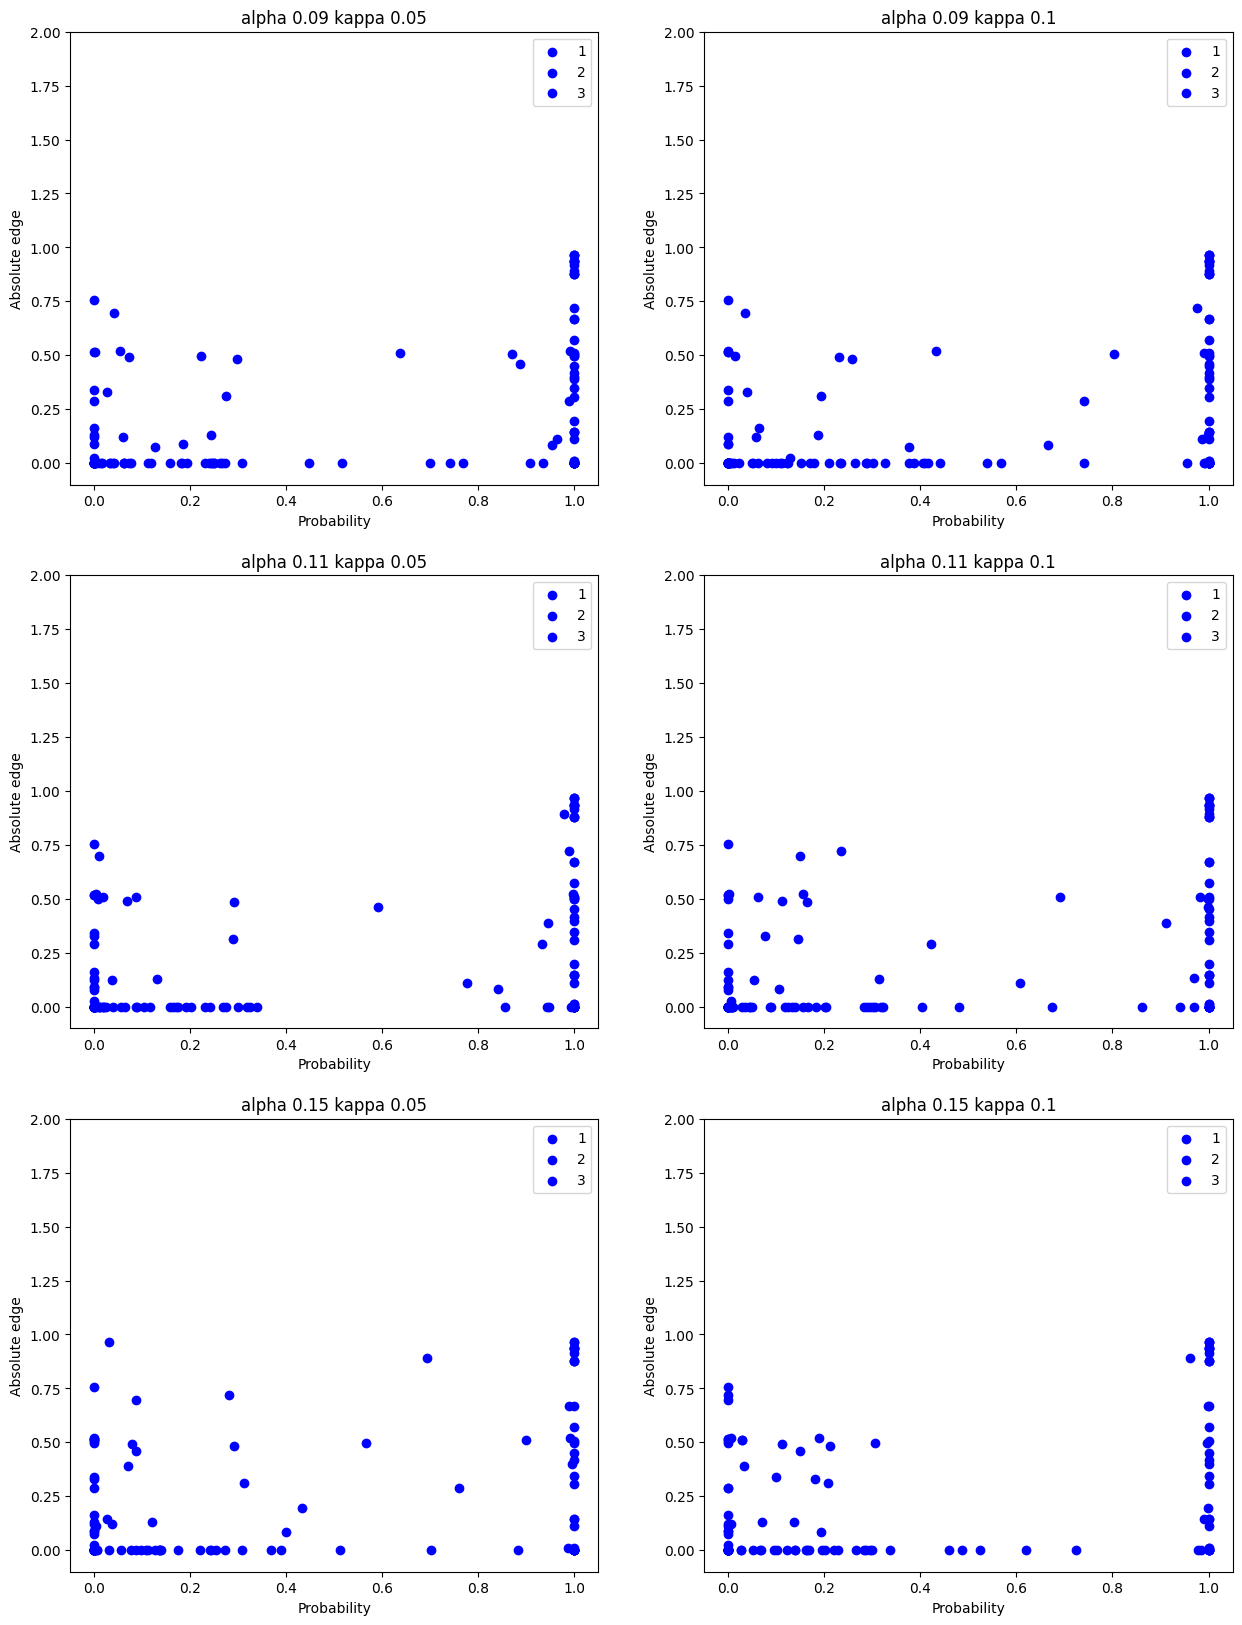

In [102]:

as_test = [4,5,6]#len(graph_sampling_testing['alphas'])
fig, ax = plt.subplots(len(as_test),2, figsize = (15,20))
for cnt, a in enumerate(as_test): #range(len(graph_sampling_testing['alphas'])):
    for k in range(2):
        ax[cnt,k].scatter(1-graph_sampling_testing['p_distribution'][k, a, 0,-1,:],np.abs(graph_sampling_testing['As'][0][np.triu_indices(10,1)]), label = '1', color = 'blue')
        ax[cnt,k].scatter(1-graph_sampling_testing['p_distribution'][k, a, 1,-1,:],np.abs(graph_sampling_testing['As'][1][np.triu_indices(10,1)]), label = '2', color = 'blue' )
        ax[cnt,k].scatter(1-graph_sampling_testing['p_distribution'][k, a, 2,-1,:],np.abs(graph_sampling_testing['As'][2][np.triu_indices(10,1)]), label = '3', color = 'blue' )
        ax[cnt,k].set_ylabel("Absolute edge")
        ax[cnt,k].set_xlabel("Probability")
        ax[cnt,k].set_xlim((0,1))
        ax[cnt,k].set_title(f"alpha {np.round(graph_sampling_testing['alphas'][a],2)} kappa {graph_sampling_testing['kappas'][k]}")
        ax[cnt,k].legend()
        ax[cnt,k].set_ylim((-0.1,2))
        ax[cnt,k].set_xlim((-0.05,1.05))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

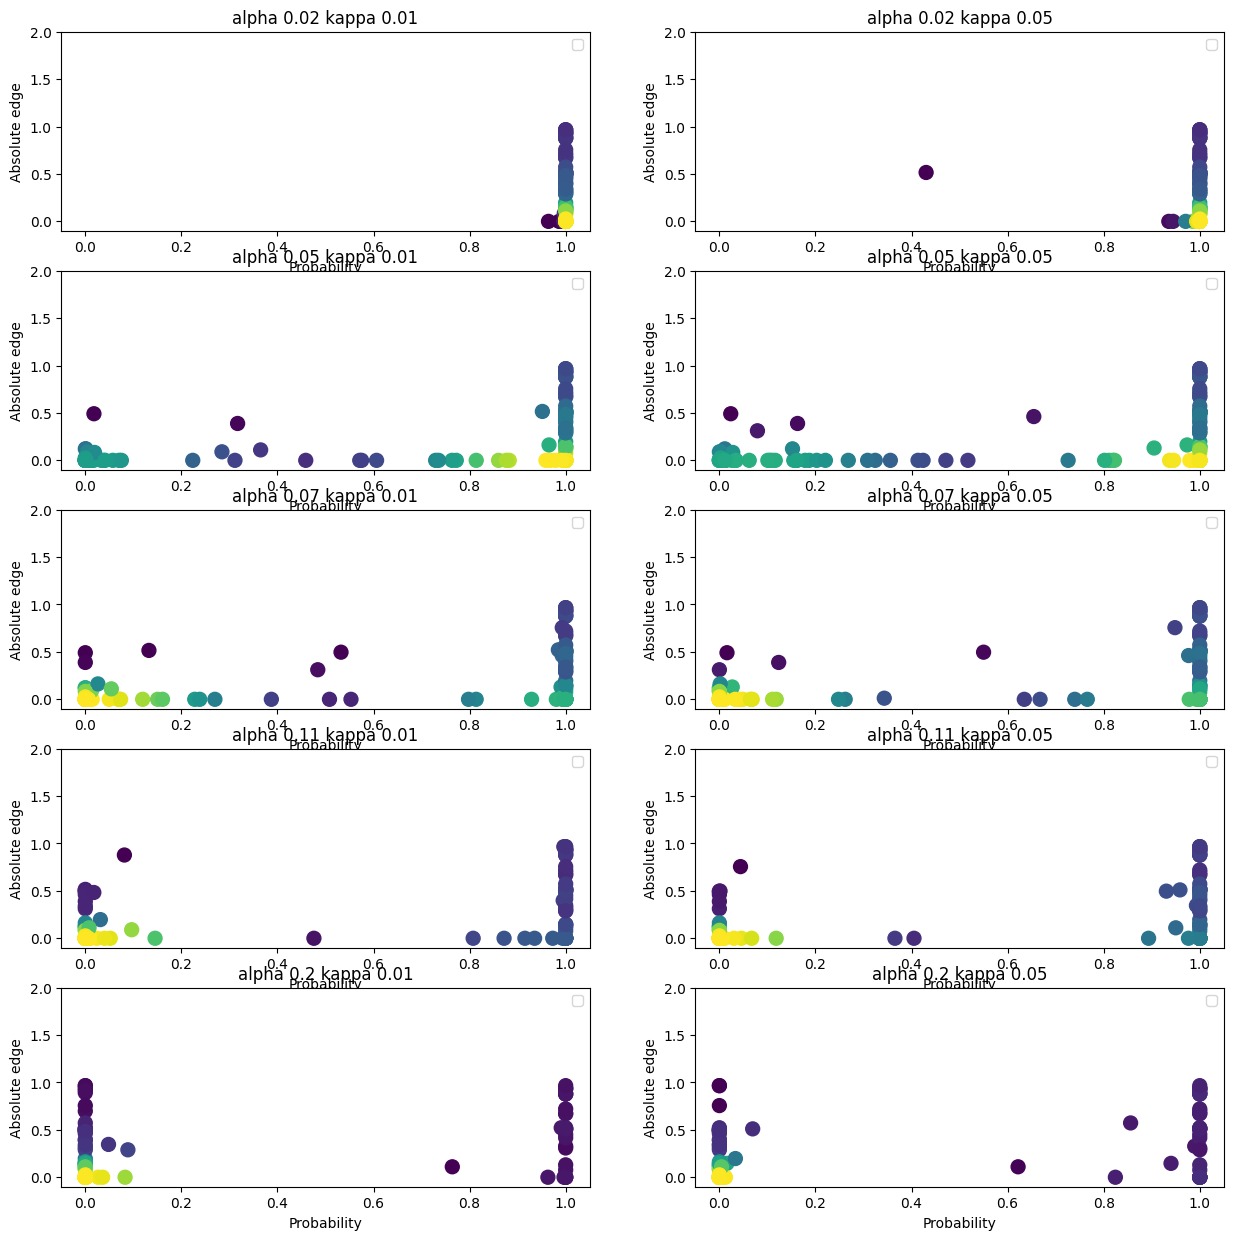

In [43]:
from scipy.stats import gaussian_kde
as_test = [1, 2, 3, 5, 7]#len(graph_sampling_testing['alphas'])
fig, ax = plt.subplots(len(as_test),2, figsize = (15,15))
for cnt, a in enumerate(as_test): #range(len(graph_sampling_testing['alphas'])):
    for k in range(2):
        x = np.concatenate((1-graph_sampling_testing['p_distribution'][k, a, 0,-1,:], 1-graph_sampling_testing['p_distribution'][k, a, 1,-1,:], 1-graph_sampling_testing['p_distribution'][k, a, 2,-1,:]))
        y = np.concatenate((np.abs(graph_sampling_testing['As'][0][np.triu_indices(10,1)]), np.abs(graph_sampling_testing['As'][1][np.triu_indices(10,1)]), np.abs(graph_sampling_testing['As'][2][np.triu_indices(10,1)])))
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)

        ax[cnt,k].scatter(x, y, c=z, s=100)
        ax[cnt,k].set_ylabel("Absolute edge")
        ax[cnt,k].set_xlabel("Probability")
        ax[cnt,k].set_xlim((0,1))
        ax[cnt,k].set_title(f"alpha {np.round(graph_sampling_testing['alphas'][a],2)} kappa {graph_sampling_testing['kappas'][k]}")
        ax[cnt,k].legend()
        ax[cnt,k].set_ylim((-0.1,2))
        ax[cnt,k].set_xlim((-0.05,1.05))

Plot P with time

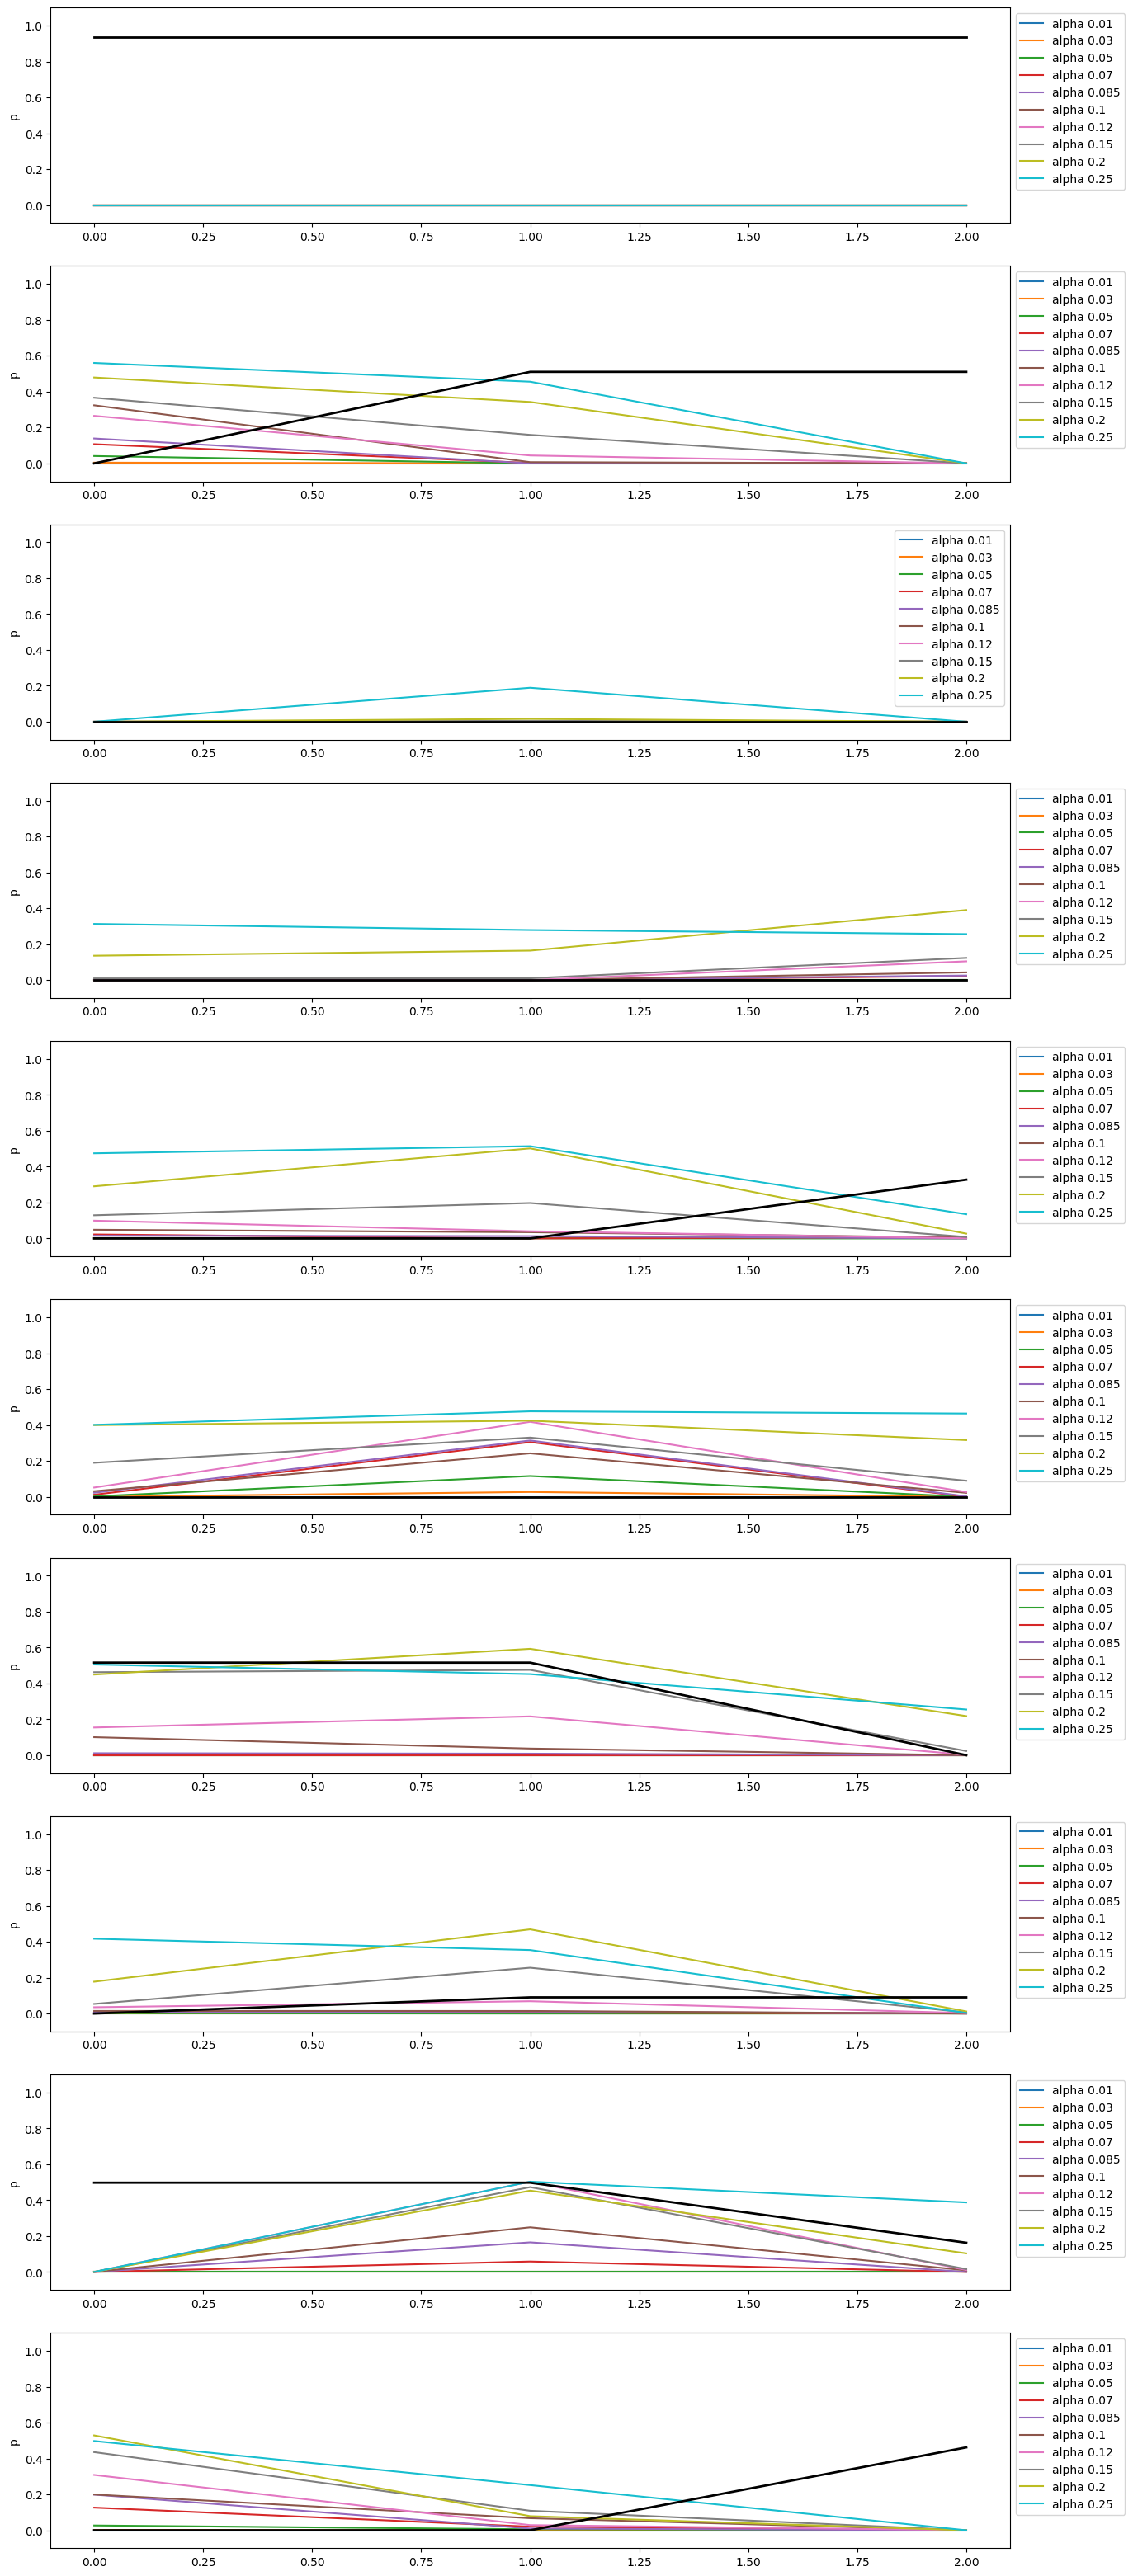

In [155]:
# For binomial
fig, ax = plt.subplots(10,1, figsize = (15,40))
for i in range(10):
    for k in [0]:
        for a in range(len(graph_sampling_testing['alphas'])):
            ax[i].plot(range(3), graph_sampling_testing['p_distribution'][k,a,:,-1,i], label = f'alpha {graph_sampling_testing["alphas"][a]}', alpha = 1)
            #A_est = graph_sampling_testing['thetas'][h,j,k][np.triu_indices(20,1)]
            #A_est[np.abs(A_est)<1e-3] = 0
            #ax[i,h].plot(range(graph_sampling_testing['p_distribution'].shape[3]),[1-np.abs(np.sign(A_est[i]))]*61, color = 'orange')
    ax[i].plot(range(3),[np.abs( graph_sampling_testing['As'][j][np.triu_indices(10,1)][i]) for j in range(3)], color = 'black',linewidth = 2)
    #ax[i,h].set_xlabel('Iteration')
    ax[i].set_ylabel('p')
    ax[i].set_ylim((-0.1,1.1))
    ax[i].legend(bbox_to_anchor = (1,1))

Thetas simulated - One edge

In [55]:
graph_sampling_testing['thetas'].shape

(2, 8, 3, 10, 10)

Text(0.5, 1.0, 'kappa 0.05')

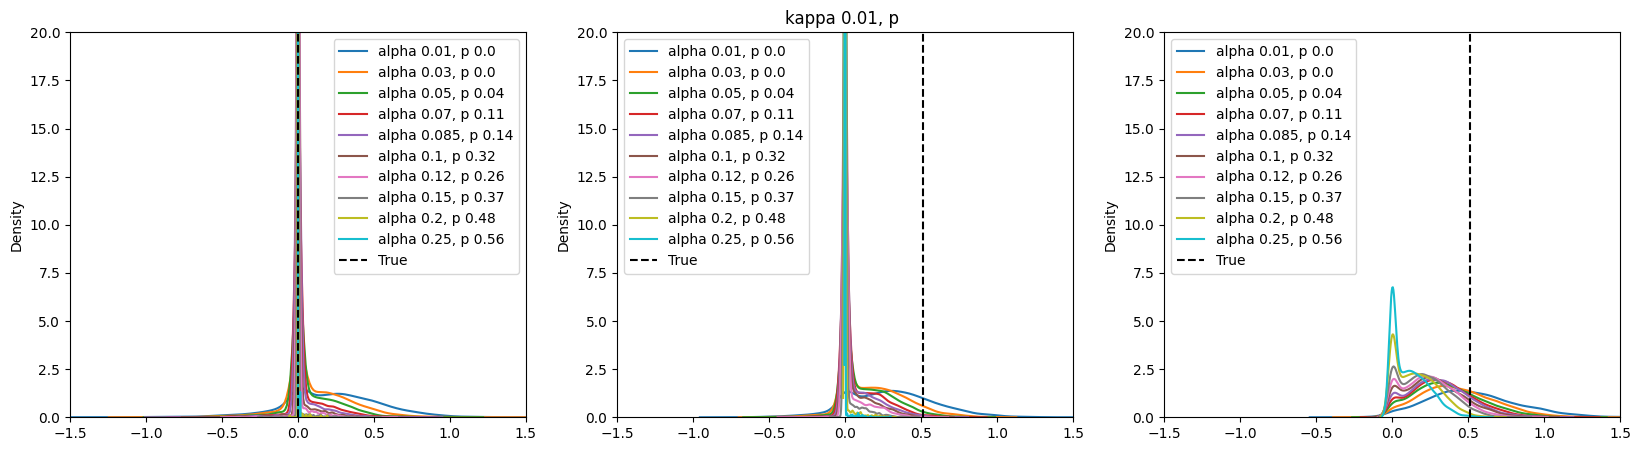

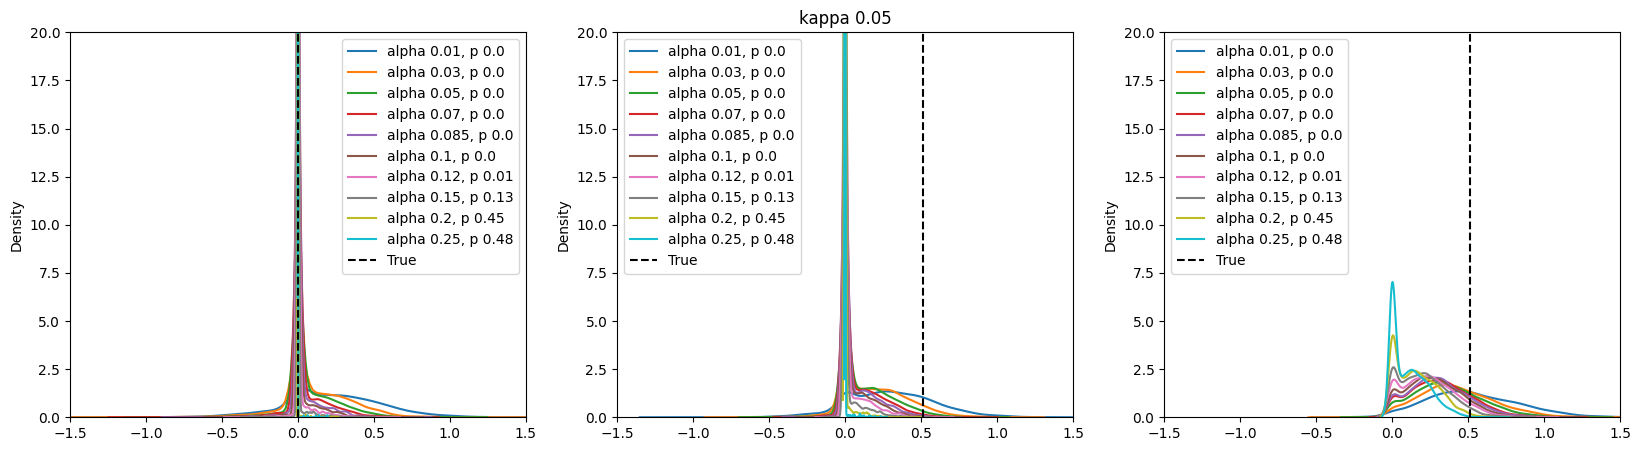

In [123]:
i = 0
j = 2

xlim = (-1.5, 1.5)

As = graph_sampling_testing['As']
fig, ax = plt.subplots(1,3, figsize = (20, 5))
k = 0
for h in range(3):
    for a in range(len(graph_sampling_testing['alphas'])):
        theta_est = graph_sampling_testing['thetas'][k,a,h].copy()
        sns.kdeplot(graph_sampling_testing['thetas_sim'][k,a,:,h,i,j], ax = ax[h], label =f'alpha {graph_sampling_testing["alphas"][a]}, p {np.round(P[k,a,h,i,j],2)}')
    #ax[h].axvline(x = theta_est[i,j], label = 'Dygl', color = 'black')
    ax[h].axvline(x = As[h][i,j], label = 'True', color = 'black', linestyle = 'dashed')
    ax[h].set_ylim((0,20))
    ax[h].legend()
    ax[h].set_xlim(xlim)
ax[1].set_title(f'kappa {graph_sampling_testing["kappas"][k]}, p ')

As = graph_sampling_testing['As']
fig, ax = plt.subplots(1,3, figsize = (20, 5))
k = 1
for h in range(3):
    for a in range(len(graph_sampling_testing['alphas'])):
        theta_est = graph_sampling_testing['thetas'][k,a,h].copy()
        sns.kdeplot(graph_sampling_testing['thetas_sim'][k,a,:,h,i,j], ax = ax[h], label =f'alpha {graph_sampling_testing["alphas"][a]}, p {np.round(P[k,a,h,i,j],2)}')
    #ax[h].axvline(x = theta_est[i,j], label = 'Dygl', color = 'black')
    ax[h].axvline(x = As[h][i,j], label = 'True', color = 'black', linestyle = 'dashed')
    ax[h].set_ylim((0,20))
    ax[h].legend()
    ax[h].set_xlim(xlim)
ax[1].set_title(f'kappa {graph_sampling_testing["kappas"][k]}')

# As = graph_sampling_testing['As']
# fig, ax = plt.subplots(1,3, figsize = (20, 5))
# k = 2
# for h in range(2):
#     for a in range(len(graph_sampling_testing['alphas'])):
#         theta_est = graph_sampling_testing['thetas'][k,a,h].copy()
#         sns.kdeplot(graph_sampling_testing['thetas_sim'][k,a,:,h,i,j], ax = ax[h], label =f'alpha {graph_sampling_testing["alphas"][a]}, p {np.round(P[k,a,h,i,j],2)}')
#     #ax[h].axvline(x = theta_est[i,j], label = 'Dygl', color = 'black')
#     ax[h].axvline(x = As[h][i,j], label = 'True', color = 'black', linestyle = 'dashed')
#     ax[h].set_ylim((0,20))
#     ax[h].legend()
#     ax[h].set_xlim(xlim)
# ax[1].set_title(f'kappa {graph_sampling_testing["kappas"][k]}')

Simulated thetes - CI

In [49]:
graph_sampling_testing['thetas_sim'].shape

(3, 10, 5000, 3, 10, 10)

In [50]:
np.mean(graph_sampling_testing['thetas_sim'][k,a,:,h], axis = 0 )

array([[ 1.27673544e+00,  2.04108630e-01,  1.17005400e-01,
         3.03042581e-02, -7.87715625e-04,  2.02458884e-03,
        -3.55099515e-04,  9.67700906e-04, -1.07423124e-02,
        -9.97170111e-04],
       [ 2.04108630e-01,  1.20198445e+00, -2.86272436e-02,
        -4.20387084e-01,  1.33104548e-01, -1.63707688e-03,
        -7.75110561e-02,  4.83867630e-01,  1.08676867e-01,
        -2.05706317e-03],
       [ 1.17005400e-01, -2.86272436e-02,  1.31563994e+00,
        -1.63191598e-01,  7.21890324e-04, -7.50177082e-03,
        -2.91484953e-02, -1.85059364e-03,  6.06507348e-02,
         6.75042271e-03],
       [ 3.03042581e-02, -4.20387084e-01, -1.63191598e-01,
         1.12100793e+00,  5.00763556e-02, -5.67598063e-02,
        -2.41842386e-02,  2.32846670e-02,  1.10900240e-01,
         2.94145465e-02],
       [-7.87715625e-04,  1.33104548e-01,  7.21890324e-04,
         5.00763556e-02,  1.77982671e+00, -3.64548756e-04,
         9.32310352e-02, -6.70126855e-04, -6.75020593e-02,
        -1.

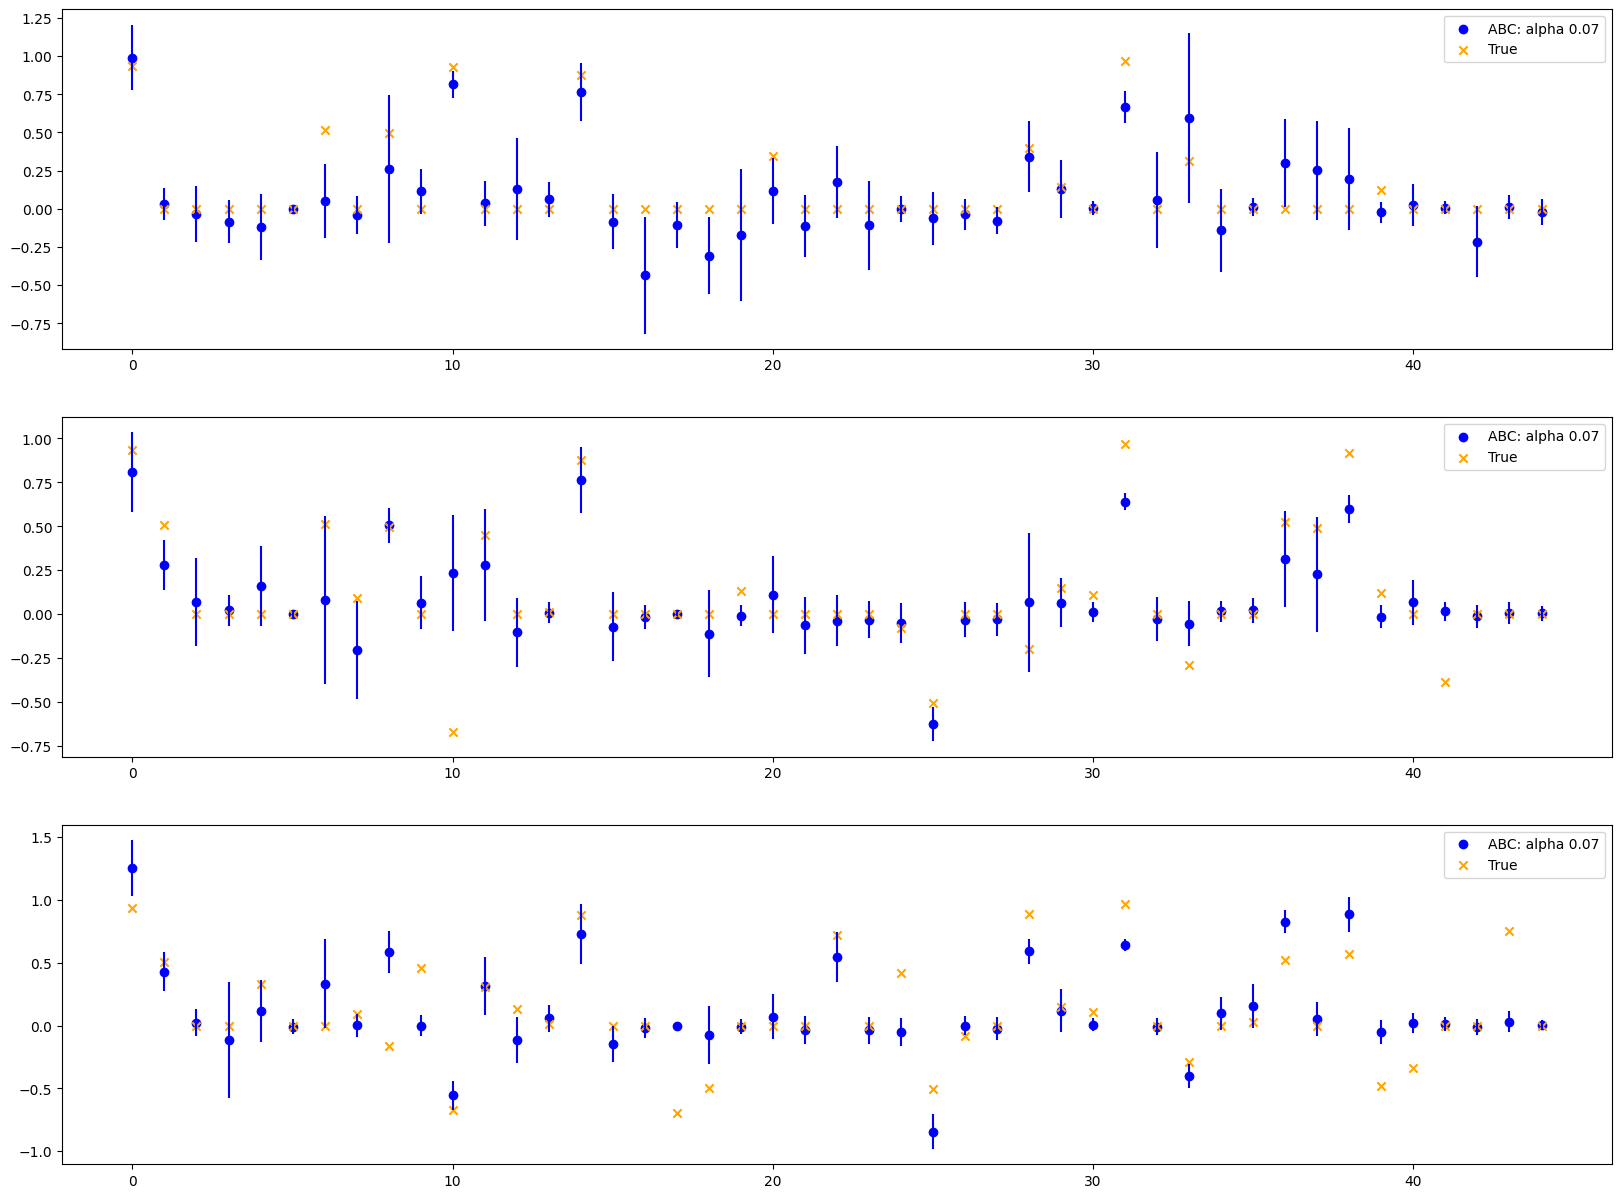

In [58]:

fig, ax = plt.subplots(3,1, figsize = (20,15))
d = 10
colors = ['blue', 'red', 'green', 'pink', 'yellow']

#for a in range(len(alphas)):
a = 3
k = 0
for h in range(3):
    #theta_est = graph_sampling_testing['thetas'][k,a,h].copy()
    #theta_est[np.abs(theta_est)<1e-3] = 0
    #theta_u = theta_est[np.triu_indices(d,1)]
    mean_u = np.mean(graph_sampling_testing['thetas_sim'][k,a,:,h], axis = 0 )[np.triu_indices(d,1)]
    std_u = np.std(graph_sampling_testing['thetas_sim'][k,a,:,h], axis = 0 )[np.triu_indices(d,1)]
    A_true_u = graph_sampling_testing['As'][h].copy()[np.triu_indices(d,1)]


    ax[h].scatter(0, mean_u[0], label =f'ABC: alpha {np.round(graph_sampling_testing["alphas"][a],2)}', color = 'blue')
    #ax[h].scatter(0, theta_u[0], label =f'Dygl: alpha {np.round(graph_sampling_testing["alphas"][a],2)}', color = 'black')
    ax[h].scatter(0, A_true_u[0], marker = 'x', label ='True', color = 'orange')
    ax[h].errorbar(0, mean_u[0], 2*std_u[0], color = 'blue')

    ax[h].legend(bbox_to_anchor = (1,1))

    for i in range(1, 45):
        ax[h].scatter(i, mean_u[i], label =f'alpha {np.round(graph_sampling_testing["alphas"][a],2)} ABC', color = 'blue')
        #ax[h].scatter(i, theta_u[i], label =f'alpha {np.round(graph_sampling_testing["alphas"][a],2)}  Dygl', color = 'black')
        ax[h].scatter(i, A_true_u[i], marker = 'x', label ='True', color = 'orange')
        ax[h].errorbar(i, mean_u[i], 2*std_u[i], color = 'blue')

simulated thetas - kde edge paths

In [89]:
graph_sampling_testing['thetas_sim'].shape

(3, 4, 30, 1000, 3, 10, 10)

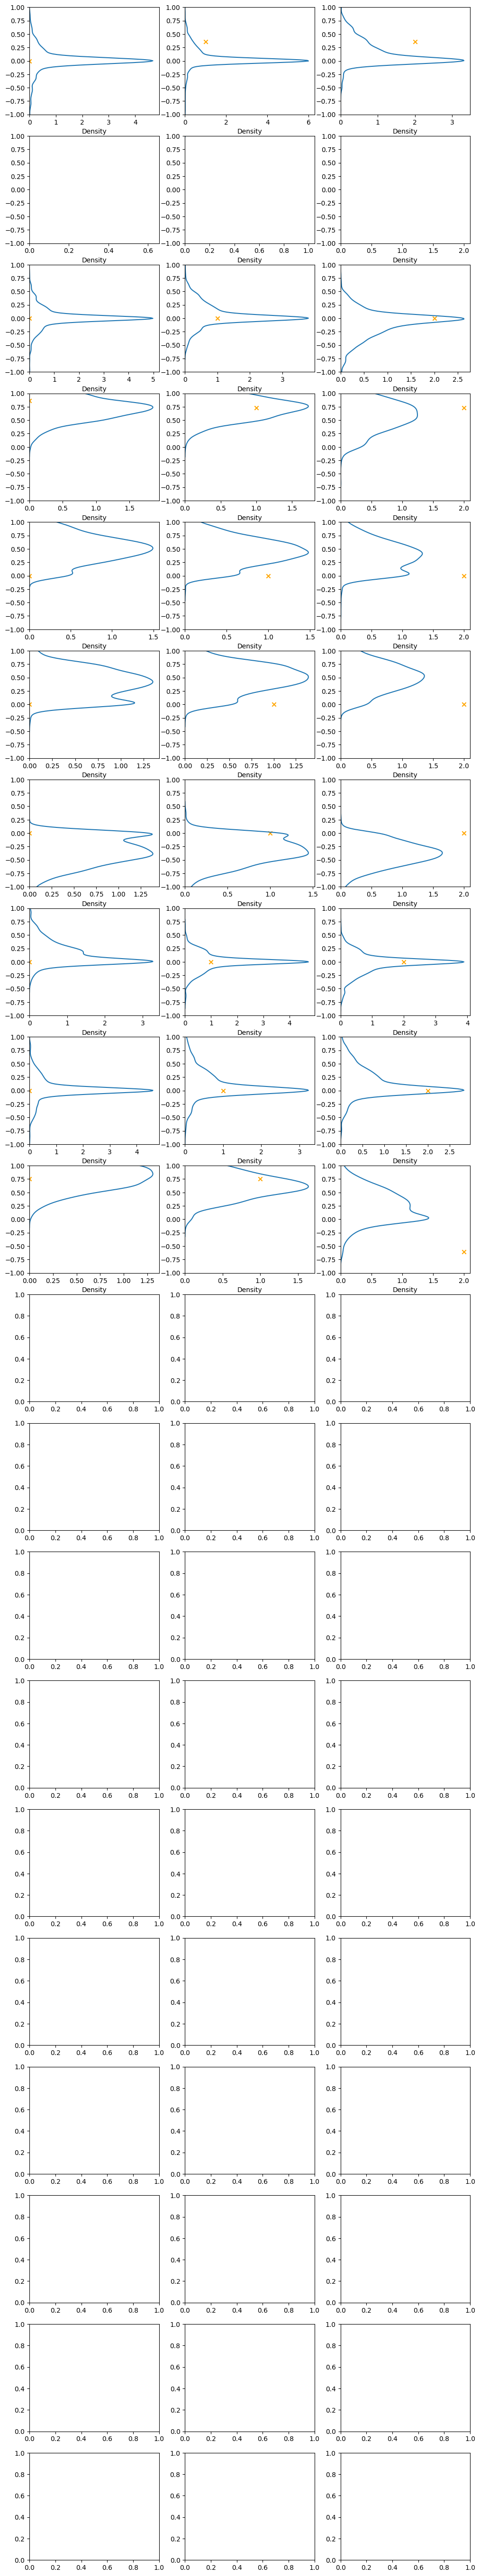

In [92]:




k = 0
a = 1

theta_est = graph_sampling_testing['thetas'][k,a].copy()
As = np.array(graph_sampling_testing['As'])
theta_est[np.abs(theta_est)<1e-3] = 0
#std_u = np.std(thetas_sim[k,a,:], axis = 1 )

fig, ax = plt.subplots(20,3, figsize = (12,70))
n_i = 1
for n_j in range(0,10):
    for h in range(3):
        #ax[n_j,h].scatter([h], theta_est[h,n_i,n_j], label ='Estimate', color = 'black')
        ax[n_j,h].scatter([h], As[h,n_i,n_j], label ='True', color = 'orange', marker = 'x' )
        sns.kdeplot(y = graph_sampling_testing['thetas_sim'][k,a,-1,:,h,n_i,n_j], ax = ax[n_j,h])
        ax[n_j,h].set_ylim((-1,1))
    #ax.legend()

Test graph estimation

In [48]:
graph_sampling_testing['X'].shape

(90, 10)

In [76]:
dg_opt1 = dg.dygl_inner_em(graph_sampling_testing['X'], obs_per_graph = 30, max_iter = 10000, lamda = 0.01, kappa =0.01, tol = 1e-4)
dg_opt1.fit(nr_workers=1, temporal_penalty="element-wise", lik_type="gaussian",verbose=False)

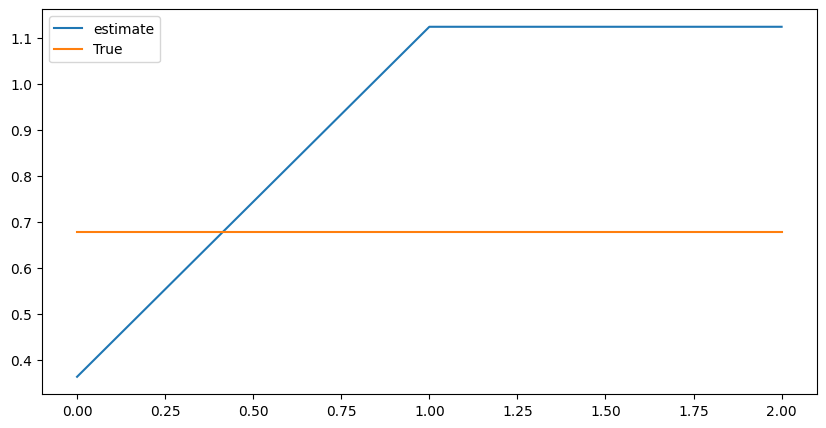

In [78]:
i = 0
j = 6

fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.plot(dg_opt1.theta[:,i,j], label = 'estimate')
ax.plot(graph_sampling_testing['As'][:,i,j],label =  'True')
ax.legend()